# Entrega 4 - Predictor de muerte de pacientes con HIV utilizando redes neuronales y regresión logistica

## 1. Objetivo

El objetivo principal de esta tarea es construir diferentes modelos de regresión logística y redes neuronales para predecir la muerte de pacientes bajo observación por HIV. Para ello, utilizaremos el dataset `AIDS Clinical Trials Group Study 175` tomando como valor a predecir el indicador de censura `cid`.

El indicador de censura puede tomar dos valores "censoring" o "failure". La censura ocurre cuando un valor de una observación solo se conoce parcialmente. 

En este caso ocurre cuando el experimento termina en un momento determinado, tras el cuál los pacientes todavía vivos quedan censurados por la derecha.  

Luego del momento de la última observación no se conocen datos sobre la muerte o supervivencia de los pacientes. Por lo que se puede tomar únicamente el caso "failure" como la muerte de un paciente.

In [1]:
import importlib
import pandas as pd
import torch.optim as optim

# sklearn:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

# Objetivo a predecir
OBJETIVO = 'cid'

dataset = pd.read_csv('data.csv')

/shared-libs/python3.9/py/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import utilidades
import modelos
import entrenador

from modelos import *
from entrenador import *

importlib.reload(utilidades)
importlib.reload(entrenador)
importlib.reload(modelos)

<module 'modelos' from '/root/work/modelos.py'>

## 2. Diseño del predictor

 ### 2.1 Entrenamiento del predictor y evaluación.

Para realizar el entrenamiento, ajuste de la solución y evaluación del modelo, el conjunto de datos es separado en 3 particiones:

- Entrenamiento (80%): Utilizado para entrenar los diferentes modelos.
- Validación (10% del conjunto de entrenamiento): Para ajustar los valores de los hiperparametros
- Evaluación (20%): Para probar la precisión de los modelos una vez entrenados.

Además, a la hora de separarlos, utilizamos el parámetro `stratify=Y` de forma que la distribución de la columna `cid` sea similar en los 3 subconjuntos.

Al momento de evaluar las soluciones se utilizan las siguientes métricas, calculadas con `scikit-learn`:

- Accuracy: $ \frac{TP + TN}{TP + TN + FP + FN}$
- Precision: $ \frac{TP}{TP + FP}$
- Recall: $ \frac{TP}{TP + FN}$
- F1: $ \frac{2 \cdot Precision}{Precision + Recall} $
- Pérdida del modelo

Estas métricas serán acompañadas con la visualización de la matriz de confusión correspondiente.

In [3]:
X = dataset.copy().drop(columns=[OBJETIVO, 'pidnum', 'time'])
Y = dataset[OBJETIVO].copy()

X_train_completo, X_test, Y_train_completo, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 12345, stratify=Y)
X_train, X_validacion, Y_train, Y_validacion = train_test_split(X_train_completo, Y_train_completo, test_size=0.1, random_state=12345, stratify=Y_train_completo)

### 2.2 Preprocesamiento de los conjuntos de datos

Hablar del porque usamos preprocesamiento: Juan Jhon Scooby y standarizacion.

Notar que una vez entrenado el standarizador, se utiliza el mismo para transformar el conjunto de validacion y de test.

In [4]:
X_train = pd.get_dummies(X_train, columns=['trt', 'strat'], drop_first=True)
X_validacion = pd.get_dummies(X_validacion, columns=['trt', 'strat'], drop_first=True)
X_test = pd.get_dummies(X_test, columns=['trt', 'strat'], drop_first=True)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_validacion = scaler.transform(X_validacion)
X_test = scaler.transform(X_test)

### 2.3 Configuración de libreria `Torch`

Hablar de que es posible usar la gráfica 

In [5]:
device = torch.device("cpu" if not torch.cuda.is_available() else "cuda")
print(device)
torch.manual_seed(2024)

cpu


### 2.4 Linea base 

Se reutiliza la línea base del _Laboratorio 1_ (predictor que siempre devuelve 0), dado que se trabaja con el mismo conjunto. Se recuerda que la clase objetivo cuenta con 1618 entradas cuyo resultado es 0 y 521 cuyo resultado es 1. 

Los resultados reportados son los siguientes:

| Métrica           | Línea base     |
|-------------------|----------------|
| Accuracy          | 0.756          |
| Precision         | 0.756          |
| Recall            | 1.0            |
| F1 Score          | 0.861          |

### 2.5 Otras decisiones


## 3. Experimentación

### 3.1 Modelo 1: Regresión logisitca con scikit-learn

In [6]:
modelo_1 = LogisticRegression()
modelo_1.fit(X_train, Y_train)

LogisticRegression()

In [7]:
Y_pred = modelo_1.predict(X_validacion)

accuracy_modelo_1 = accuracy_score(Y_validacion, Y_pred)
confusion_matrix_modelo_1 = confusion_matrix(Y_validacion, Y_pred)

print(f'Precisión del modelo: {accuracy_modelo_1:.2f}')
print('Matriz de confusión:')
print(confusion_matrix_modelo_1)

Precisión del modelo: 0.78
Matriz de confusión:
[[125   5]
 [ 32  10]]


### 3.2 Modelo 2: Red neuronal de una sola neurona sin función de activación

In [24]:
cant_caracteristicas = X_train.shape[1]
modelo_2 = Modelo_2(cant_caracteristicas).to(device)

In [25]:
data_loader_train = utilidades.crear_data_loader_dual(X_train, Y_train, batch_size=8, device=device)
data_loader_validacion = utilidades.crear_data_loader_dual(X_validacion, Y_validacion, batch_size=8, device=device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(modelo_2.parameters(), lr=0.0035)
entrenador = Entrenador(modelo_2, data_loader_train, criterion, optimizer)

losses_train = []
losses_validacion = []
accuracy_train_evolucion = []
accuracy_validacion_evolucion = []
epocas = 100

for epoca in range(epocas):
    _ = entrenador.entrenar()

    loss_train = entrenador.evaluar_loss(data_loader_train)
    loss_validacion = entrenador.evaluar_loss(data_loader_validacion)
    losses_train.append(loss_train)
    losses_validacion.append(loss_validacion)

    accuracy_train = entrenador.evaluar_accuracy_dual(data_loader_train)
    accuracy_validacion = entrenador.evaluar_accuracy_dual(data_loader_validacion)
    accuracy_train_evolucion.append(accuracy_train)
    accuracy_validacion_evolucion.append(accuracy_validacion)

    if epoca % 10 == 0:
        print(f'Epoca {epoca} completada') 

Epoca 0 completada
Epoca 10 completada
Epoca 20 completada
Epoca 30 completada
Epoca 40 completada
Epoca 50 completada
Epoca 60 completada
Epoca 70 completada
Epoca 80 completada
Epoca 90 completada


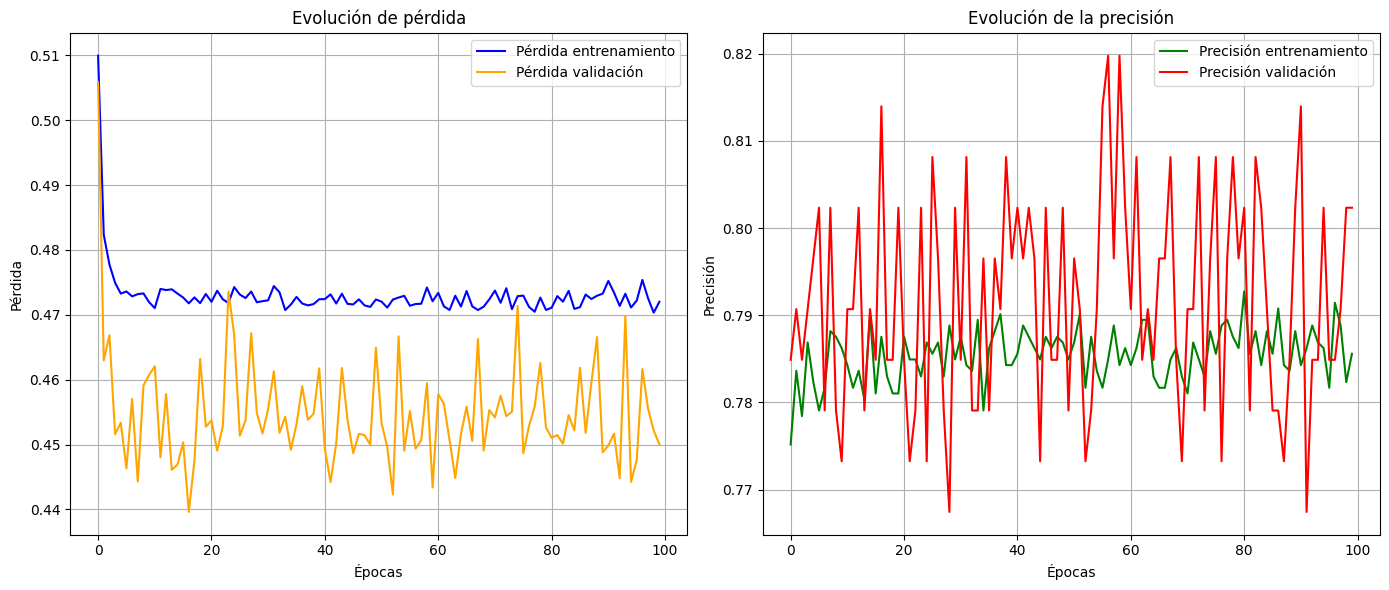

In [26]:
utilidades.graficar_metricas(losses_train, losses_validacion, accuracy_train_evolucion, accuracy_validacion_evolucion)

### 3.3 Modelo 3: Red neuronal de una sola neurona con función de activación

In [27]:
cant_caracteristicas = X_train.shape[1]
modelo_3 = Modelo_3(cant_caracteristicas).to(device)

In [28]:
data_loader_train = utilidades.crear_data_loader_singular(X_train, Y_train, batch_size=8, device=device)
data_loader_validacion = utilidades.crear_data_loader_singular(X_validacion, Y_validacion, batch_size=8, device=device)

criterion = nn.BCELoss()
optimizer = optim.Adam(modelo_3.parameters(), lr=0.0035)
entrenador = Entrenador(modelo_3, data_loader_train, criterion, optimizer)

losses_train = []
losses_validacion = []
accuracy_train_evolucion = []
accuracy_validacion_evolucion = []
epocas = 100

for epoca in range(epocas):
    _ = entrenador.entrenar()

    loss_train = entrenador.evaluar_loss(data_loader_train)
    loss_validacion = entrenador.evaluar_loss(data_loader_validacion)
    losses_train.append(loss_train)
    losses_validacion.append(loss_validacion)

    accuracy_train = entrenador.evaluar_accuracy_singular(data_loader_train)
    accuracy_validacion = entrenador.evaluar_accuracy_singular(data_loader_validacion)
    accuracy_train_evolucion.append(accuracy_train)
    accuracy_validacion_evolucion.append(accuracy_validacion)

    if epoca % 10 == 0:
        print(f'Epoca {epoca} completada') 

Epoca 0 completada
Epoca 10 completada
Epoca 20 completada
Epoca 30 completada
Epoca 40 completada
Epoca 50 completada
Epoca 60 completada
Epoca 70 completada
Epoca 80 completada
Epoca 90 completada


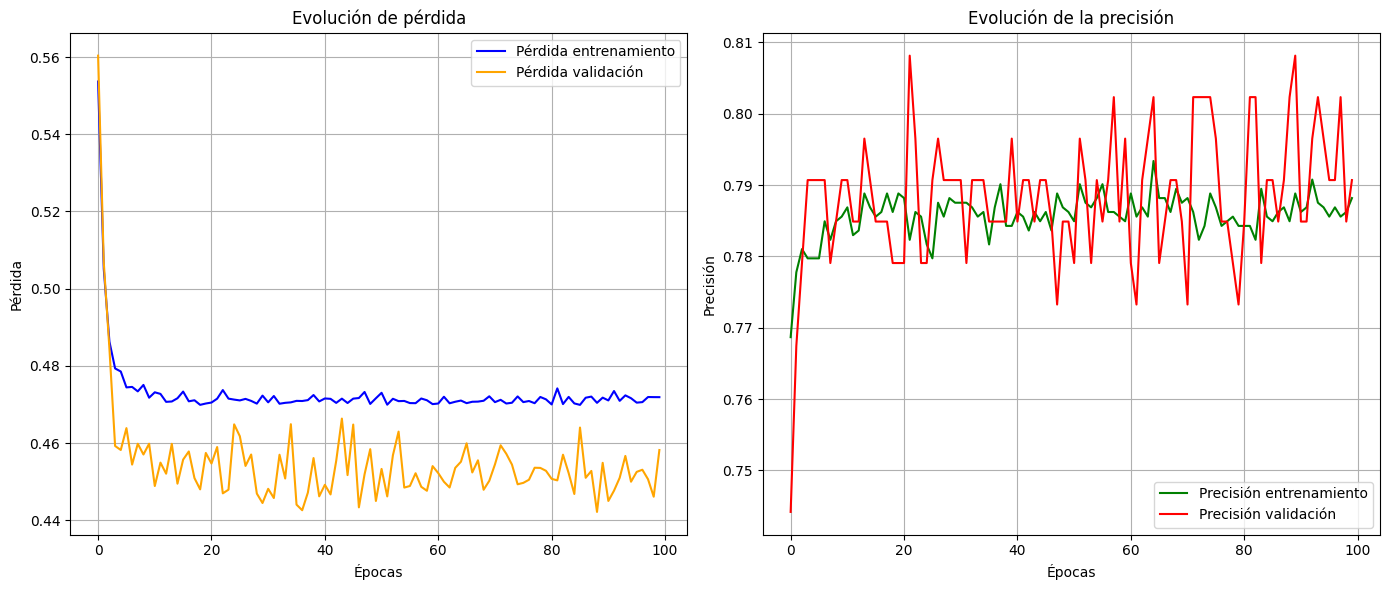

In [29]:
utilidades.graficar_metricas(losses_train, losses_validacion, accuracy_train_evolucion, accuracy_validacion_evolucion)

### 3.4 Modelo 4: Red neuronal con capas ocultas y función de activación

In [30]:
cant_caracteristicas = X_train.shape[1]
modelo_4 = Modelo_4(cant_caracteristicas).to(device)

data_loader_train = utilidades.crear_data_loader_singular(X_train, Y_train, batch_size=8, device=device)
data_loader_validacion = utilidades.crear_data_loader_singular(X_validacion, Y_validacion, batch_size=8, device=device)

#criterion_4 = nn.CrossEntropyLoss()
criterion_4 = nn.BCELoss()
#criterion_4 = nn.BCEWithLogitsLoss()

optimizer_4 = optim.Adam(modelo_4.parameters(), lr=0.0035)
'''
optimizer_4 = optim.SGD(
    modelo_4.parameters(),
    lr=0.2,
    weight_decay=0.0,
    momentum=0.00
    )
'''

entrenador_4 = Entrenador(modelo_4, data_loader_train, criterion_4, optimizer_4)

losses_train = []
losses_validacion = []
accuracy_train_evolucion = []
accuracy_validacion_evolucion = []
epocas = 100

for epoca in range(epocas):
    _ = entrenador_4.entrenar()
    
    loss_train = entrenador_4.evaluar_loss(data_loader_train)
    loss_validacion = entrenador_4.evaluar_loss(data_loader_validacion)
    losses_train.append(loss_train)
    losses_validacion.append(loss_validacion)

    accuracy_train = entrenador_4.evaluar_accuracy_singular(data_loader_train)
    accuracy_validacion = entrenador_4.evaluar_accuracy_singular(data_loader_validacion)
    accuracy_train_evolucion.append(accuracy_train)
    accuracy_validacion_evolucion.append(accuracy_validacion)

    if epoca % 10 == 0:
        print(f'Epoca {epoca} completada')

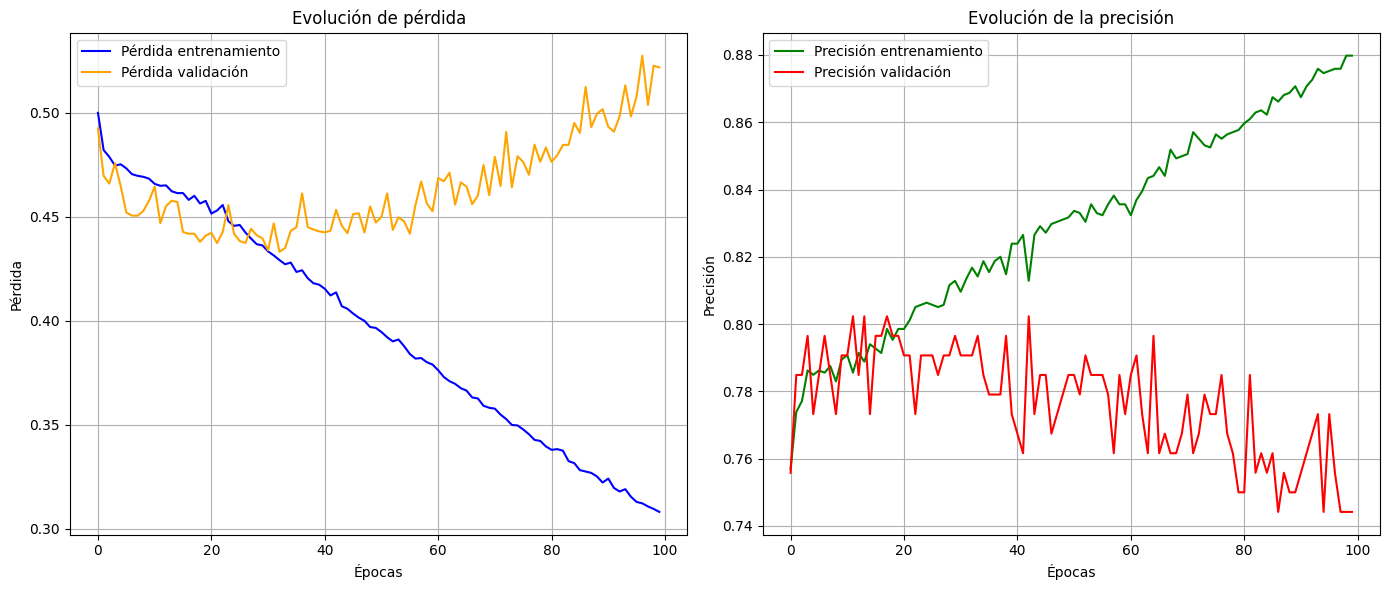

In [31]:
utilidades.graficar_metricas(losses_train, losses_validacion, accuracy_train_evolucion, accuracy_validacion_evolucion)

### 3.5 Modelo 5: Experimentación de arquitecturas

In [9]:
tamanio_entrada = X_train.shape[1]
modelo_5_1 = Modelo_5_1(tamanio_entrada).to(device) 
print(modelo_5_1)

Modelo_5_1(
  (red): Sequential(
    (0): Linear(in_features=25, out_features=4, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=4, out_features=2, bias=True)
    (4): Softmax(dim=1)
  )
)


In [10]:
data_loader_train = utilidades.crear_data_loader_dual(X_train, Y_train, batch_size=8, device=device)
data_loader_validacion = utilidades.crear_data_loader_dual(X_validacion, Y_validacion, batch_size=8, device=device)

funcion_perdida = nn.CrossEntropyLoss()
optimizador = torch.optim.Adam(modelo_5_1.parameters(), lr=0.001)
entrenador_5_1 = Entrenador(modelo_5_1, data_loader_train, funcion_perdida, optimizador)

num_epocas = 200
evolucion_accuracy_train = []
evolucion_accuracy_validacion = []
evolucion_loss_train = []
evolucion_loss_validacion = []

for epoch in range(num_epocas):
    entrenador_5_1.entrenar()

    accuracy_train = entrenador_5_1.evaluar_accuracy_dual(data_loader_train)
    loss_train = entrenador_5_1.evaluar_loss(data_loader_train)
    accuracy_validacion = entrenador_5_1.evaluar_accuracy_dual(data_loader_validacion)
    loss_validacion = entrenador_5_1.evaluar_loss(data_loader_validacion)

    if epoch % 10 == 0:
        print(f'Epoca {epoch} completada')

    # Almacenar resultados
    evolucion_accuracy_train.append(accuracy_train)
    evolucion_accuracy_validacion.append(accuracy_validacion)
    evolucion_loss_train.append(loss_train)
    evolucion_loss_validacion.append(loss_validacion)

Epoca 0 completada
Epoca 10 completada
Epoca 20 completada
Epoca 30 completada
Epoca 40 completada
Epoca 50 completada
Epoca 60 completada
Epoca 70 completada
Epoca 80 completada
Epoca 90 completada
Epoca 100 completada
Epoca 110 completada
Epoca 120 completada
Epoca 130 completada
Epoca 140 completada
Epoca 150 completada
Epoca 160 completada
Epoca 170 completada
Epoca 180 completada
Epoca 190 completada


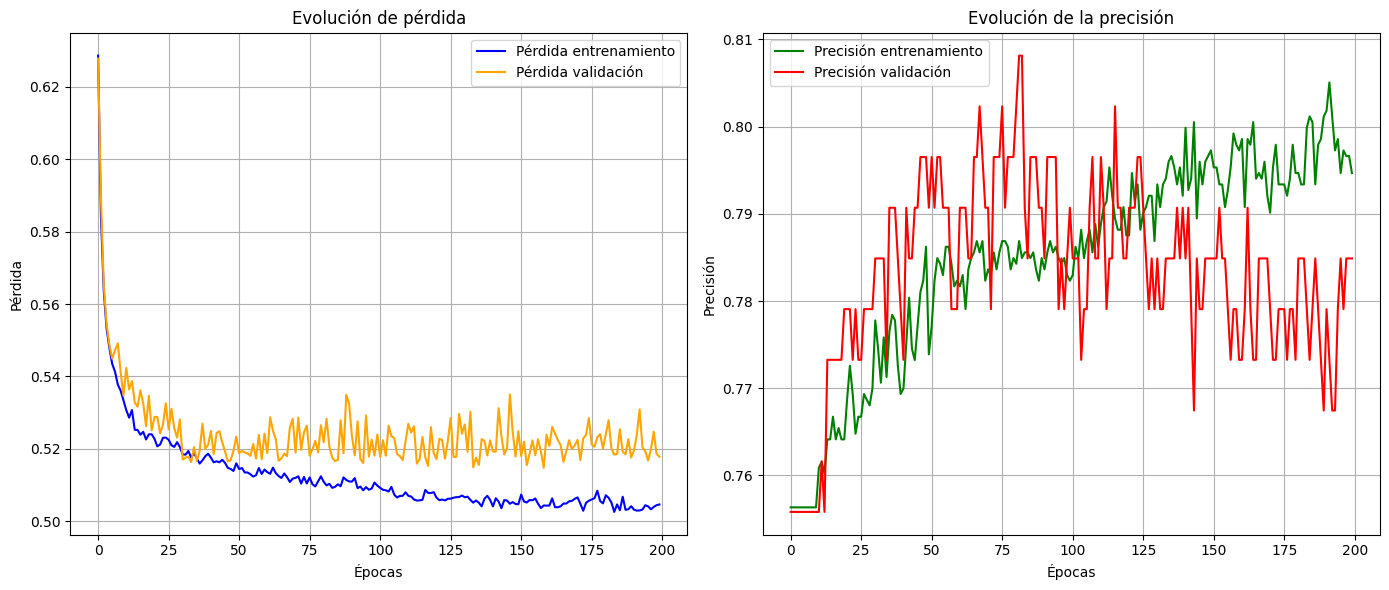

In [11]:
utilidades.graficar_metricas(evolucion_loss_train, evolucion_loss_validacion, evolucion_accuracy_train, evolucion_accuracy_validacion)

## 4. Comparación

### 4.2 Resultados de la comparación

## 5. Conclusiones

A modo de conclusión general, se logra implementar un predictor de mortalidad en pacientes con VIH utilizando árboles de decisión generados con el algoritmo ID3.

En particular, se prueban distintas configuraciones de hiper-parámetros y funciones de atributos. La combinación con mejor resultado fue utilizando la función `gain ratio`, con max_range_split de 3 y categorización _«in situ»_.

Las métricas de clasificación dieron una _accuracy_ de 0.84 y una puntuación f1 de 0.90 para la mejor configuración. Y este es competitivo con la implementación de Árboles de `scikit-learn` y, si bien el rendimiento es estrictamente inferior, es comparable con la implementación de Random Forest de la misma librería. 

Como mejoras a futuro podríamos listar:
- Explorar otros métodos de preprocesamiento de datos, como por ejemplo la selección de atributos en el dataset.
- Probar métodos más complejos como Random Forest.
- Aplicar técnicas para reducir el overfitting en caso de haberlo, como puede ser early stopping.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=d290ba77-f85f-4658-8168-f585f89f4dfe' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>